<a href="https://colab.research.google.com/github/gauravmahendraker/ViT_Classification/blob/main/classification_ViT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install kaggle

In [ ]:
! mkdir ~/.kaggle



In [ ]:
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download mustafaalgun/covid19-chest-xray-dataset

100% 1.34G/1.34G [01:04<00:00, 22.0MB/s]
100% 1.34G/1.34G [01:04<00:00, 22.4MB/s]


Downloading dataset to drive

In [ ]:
# !mkdir -p '/content/drive/MyDrive/BTP_GAURAV/Deep_Learning/Dataset'

# !mv /content/covid19-chest-xray-dataset.zip '/content/drive/MyDrive/BTP_GAURAV/Deep_Learning/Dataset/'

In [ ]:
!unzip /content/drive/MyDrive/BTP_GAURAV/Deep_Learning/Dataset/covid19-chest-xray-dataset.zip

Importing Necessary Libraries and Packages


In [ ]:
import numpy as np
import pandas as pd

import glob, random, os, warnings
import matplotlib.pyplot as plt
from datetime import datetime
from tqdm import tqdm
import seaborn as sns
from time import time
import time as t
import shutil
import cv2

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


import tensorflow as tf
import tensorflow.keras.layers as L
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator

#To get the same results in different environments
def seed_everything(seed = 0):
    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    os.environ['TF_DETERMINISTIC_OPS'] = "True"
    os.environ["TF_DISABLE_SEGMENT_REDUCTION_OP_DETERMINISM_EXCEPTIONS"] = "True"

seed_everything()
warnings.filterwarnings('ignore')


print('TensorFlow Version ' + tf.__version__)

TensorFlow Version 2.15.0


In [ ]:
image_size = 224
batch_size = 32
n_classes = 3
learning_rate = 0.001
weight_decay = 0.0001
num_epochs = 150

mlp_rate = 2
patch_size = 16  # Size of the patches to be used while extracting them from images
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 4
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  # Size of the transformer layers
transformer_layers = 8

In [ ]:
class_to_label_map = {'pneumonia' : 2, 'covid' : 1, 'normal' : 0}

Commented code to be run only once

In [ ]:
df = pd.DataFrame(columns =['class', 'directory'])
data_path="/content/covid19-pneumonia-normal-chest-xraypa-dataset/COVID19_Pneumonia_Normal_Chest_Xray_PA_Dataset/"
for path, names, filenames in os.walk(data_path+"normal"):
    for filename in filenames:
        df.loc[-1] = ["normal", ('normal/' + filename)]
        df.index = df.index + 1
        df = df.sort_index()
for path, names, filenames in os.walk(data_path+"covid"):
    for filename in filenames:
        df.loc[-1] = ["covid", ('covid/' + filename)]
        df.index = df.index + 1
        df = df.sort_index()
for path, names, filenames in os.walk(data_path+"pneumonia"):
    for filename in filenames:
        df.loc[-1] = ["pneumonia", ('pneumonia/' + filename)]
        df.index = df.index + 1
        df = df.sort_index()

In [ ]:
df


,class,directory
0,pneumonia,pneumonia/person1343_virus_2317.jpeg
1,pneumonia,pneumonia/person1488_virus_2593.jpeg
2,pneumonia,pneumonia/person489_bacteria_2067.jpeg
3,pneumonia,pneumonia/person1344_bacteria_3421.jpeg
4,pneumonia,pneumonia/00007444_003.png
...,...,...
4570,normal,normal/00000664_000.png
4571,normal,normal/00000814_003.png
4572,normal,normal/00000564_000.png
4573,normal,normal/00000857_000.png


Data Distribution (Data set is balanced)

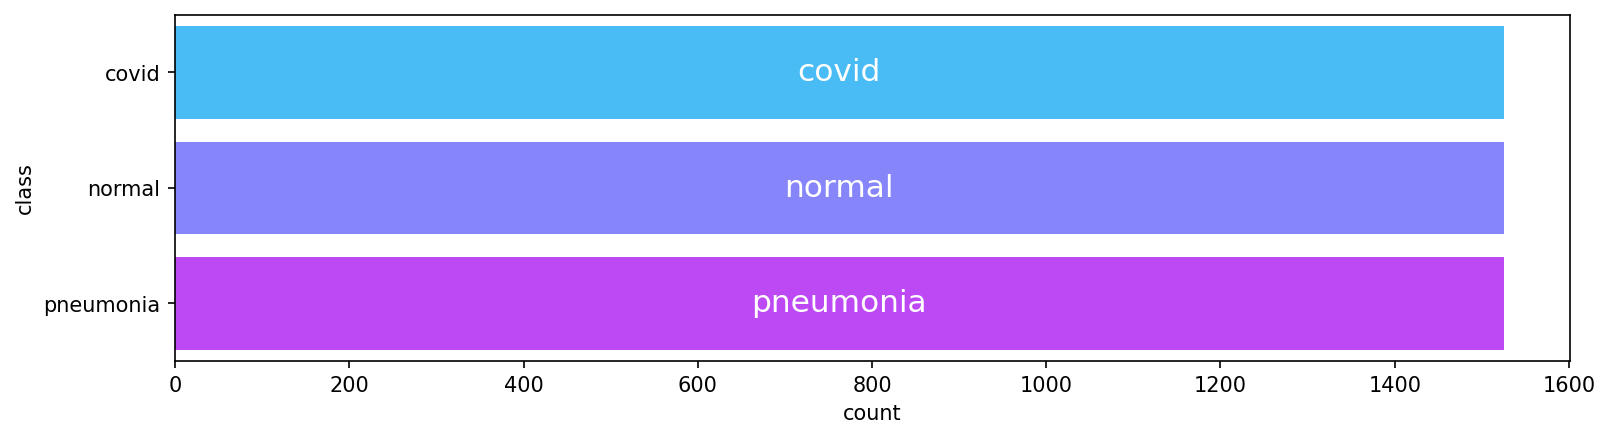

In [ ]:
plt.rcParams['figure.dpi'] = 150
plt.style.use('tableau-colorblind10')

plt.figure(figsize=(12,3))
splot = sns.countplot(data = df.sort_values(by='class'), y ='class', palette='cool', saturation=0.9)
plt.bar_label(container=splot.containers[0],
              labels=['covid', 'normal', 'pneumonia'],
              label_type='center', size=15, color='w')

plt.show()

lets see one of the image


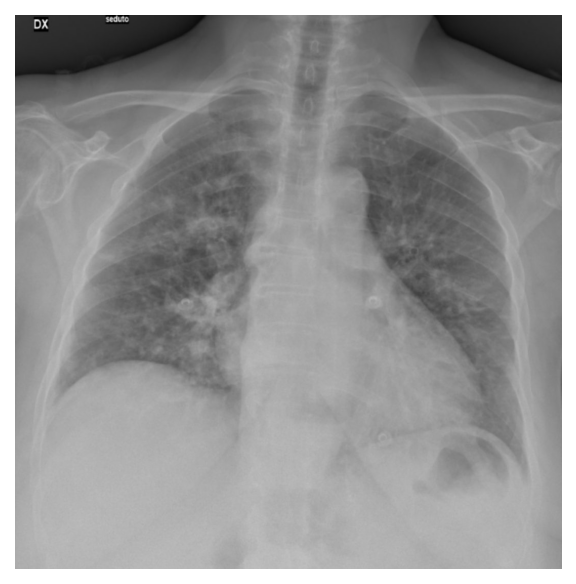

In [ ]:
plt.figure()
image = cv2.imread(data_path+"covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C-1068x1083.jpeg")
plt.imshow(image)
plt.axis('off')
plt.show()

print('Image Shape: {}'.format(image.shape))
print('Image Height: {}'.format(image.shape[0]))
print('Image Width: {}'.format(image.shape[1]))
print('Image Dimension: {}'.format(image.ndim))
print('Image Size: {}kb'.format(image.size//1024))
print('Image Data Type: {}'.format(image.dtype))
print('Maximum RGB value of the image: {}'.format(image.max()))
print('Minimum RGB value of the image: {}'.format(image.min()))

Train Test Split

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(df['directory'], df['class'], stratify= df['class'], test_size=0.20, random_state=1)
print(f"""

# Train samples: {Y_train.shape}
# Test samples: {Y_test.shape}

""")

Image Shape: (1083, 1068, 3)
Image Height: 1083
Image Width: 1068
Image Dimension: 3
Image Size: 3388kb
Image Data Type: uint8
Maximum RGB value of the image: 255
Minimum RGB value of the image: 0


# Train samples: (3660,)
# Test samples: (915,)




In [ ]:
def copy_images(df, directory):
    input_path = data_path
    output_path = data_path+"out/" + directory

    #if any old file exists in ouput path, it is removed
    if os.path.exists(output_path):
        shutil.rmtree(output_path)

    #creating folder inside output path
    if not os.path.exists(output_path):
        os.makedirs(output_path)

    #these three subfolders
    classes = ['normal', 'covid', 'pneumonia']
    for c in classes:
        if not os.path.exists(output_path + '/' + c):
            os.makedirs(output_path + '/' + c)

    #the original dataframe containing directory for each row, those directory are shifted from path_from to path_to
    #(that is from input directory to ouput directory)
    for i, row in df.iterrows():
        path_from = "{}/{}".format(input_path, row['directory'])
        path_to = "{}/{}".format(output_path, row['directory'])
        shutil.copy(path_from, path_to)

In [ ]:
df_test = pd.concat([X_test, Y_test], axis = 1)
df_train = pd.concat([X_train, Y_train], axis = 1)

copy_images(df_test, 'test')
copy_images(df_train, 'train')

Here I import one of the images, then turn it into a tensor. Finally, I plot it. We'll use this image to show data augmentation techniques in the cell below this cell.

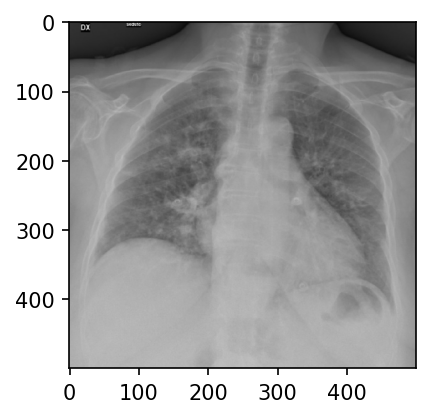

In [ ]:
image_path = data_path+"covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C-1068x1083.jpeg"
#Loads image in from the set image path
img = tf.keras.preprocessing.image.load_img(image_path, target_size= (500,500))
img_tensor = tf.keras.preprocessing.image.img_to_array(img)
img_tensor = np.expand_dims(img_tensor, axis=0)
#Allows us to properly visualize our image by rescaling values in array
img_tensor /= 255.
#Plots image
plt.figure(figsize=(3,3))
plt.imshow(img_tensor[0])
plt.show()

Data Augmentation

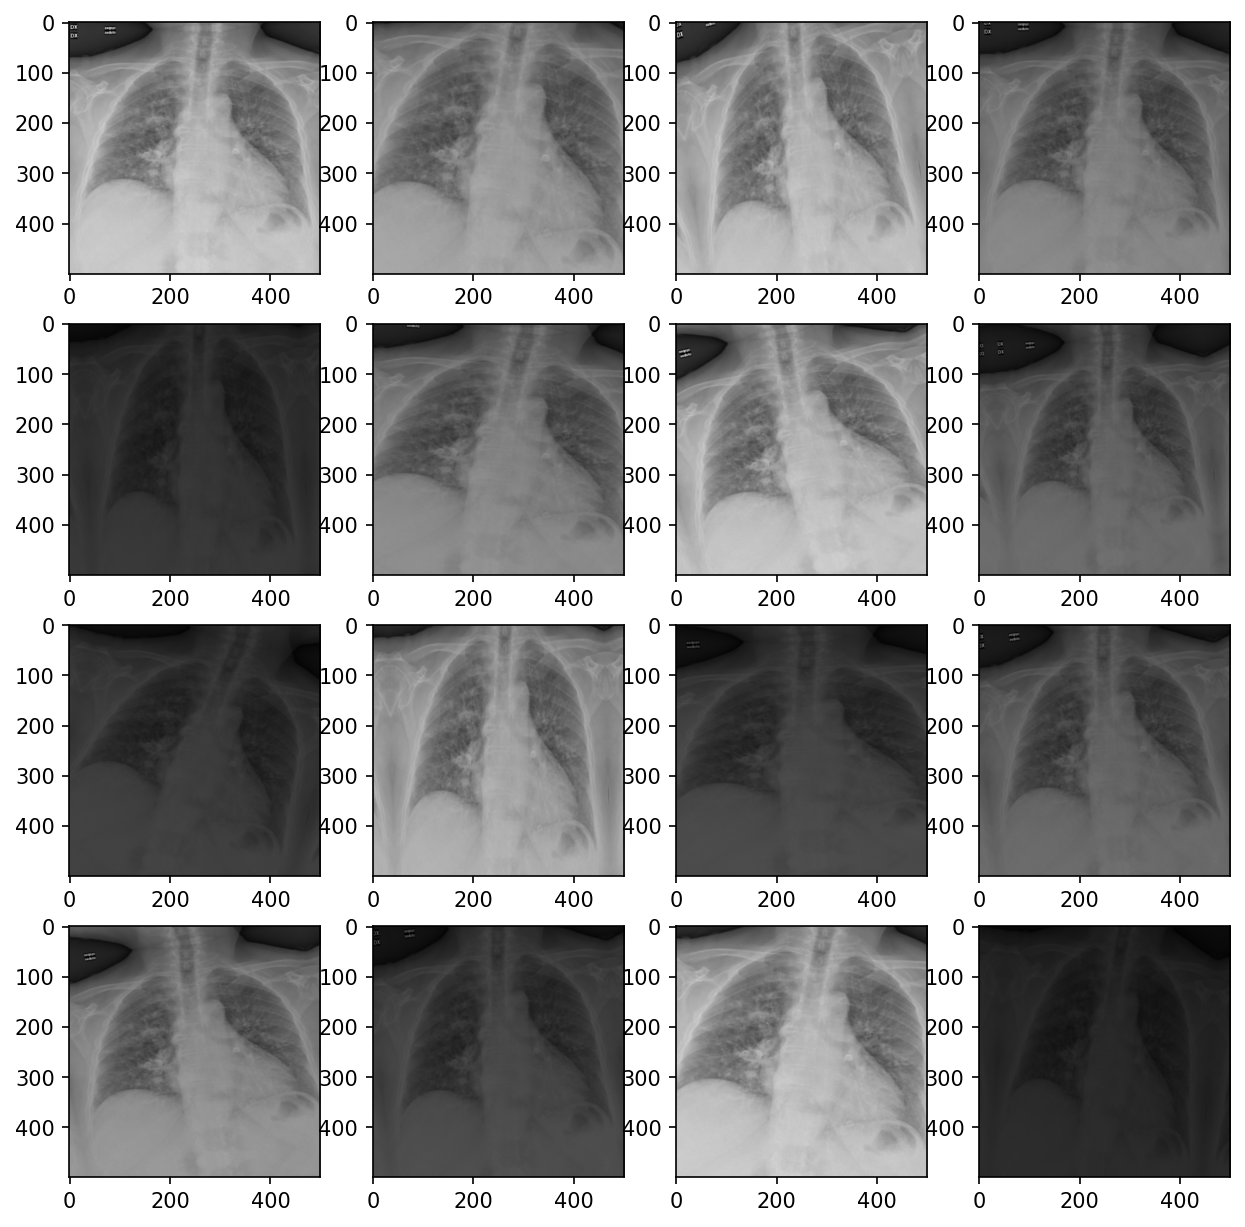

In [ ]:
datagen = ImageDataGenerator(featurewise_center = "True",
                            featurewise_std_normalization = "True",
                            shear_range = 0.25,
                            zoom_range = 0.2,
                            rotation_range = 15,
                            brightness_range = [0.15, 1.15],
                            width_shift_range = [-2,-1, 0, +1, +2],
                            height_shift_range = [ -1, 0, +1],
                            fill_mode = 'reflect')
#Creates our batch of one image
pic = datagen.flow(img_tensor*255, batch_size =1)
plt.figure(figsize=(10, 10))
#Plots our figures
for i in range(1,17):
    plt.subplot(4, 4, i)
    batch = pic.next()
    image_ = batch[0].astype('uint8')
    plt.imshow(image_)
plt.show()

Image Data Generator

In [ ]:

test_path = data_path+"out/test"
train_path =data_path+"out/train"

#Data augmentation methods are applied here!
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                            validation_split = 0.2,
                                                            featurewise_center = "True",
                                                            featurewise_std_normalization = "True",
                                                            shear_range = 0.25,
                                                            zoom_range = 0.2,
                                                            rotation_range = 15,
                                                            brightness_range = [0.15, 1.15],
                                                            width_shift_range = [-2,-1, 0, +1, +2],
                                                            height_shift_range = [ -1, 0, +1],
                                                            fill_mode = 'reflect')

#Different generator
test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_gen = datagen.flow_from_dataframe(dataframe = df_train,
                                        directory = train_path,
                                        x_col = 'directory',
                                        y_col = 'class',
                                        subset = 'training',
                                        batch_size = batch_size,
                                        seed = 1,
                                        color_mode = 'grayscale',
                                        shuffle = True,
                                        class_mode = 'categorical',
                                        target_size = (image_size, image_size))

valid_gen = datagen.flow_from_dataframe(dataframe = df_train,
                                        directory = train_path,
                                        x_col = 'directory',
                                        y_col = 'class',
                                        subset = 'validation',
                                        batch_size = batch_size,
                                        seed = 1,
                                        color_mode = 'grayscale',
                                        shuffle = True,
                                        class_mode = 'categorical',
                                        target_size = (image_size, image_size))


test_gen = test_datagen.flow_from_directory(
    directory=test_path,
    color_mode="grayscale",
    batch_size=1,
    class_mode=None,
    shuffle=False,
    seed=1,
    target_size = (image_size, image_size)
)

Found 2928 validated image filenames belonging to 3 classes.
Found 732 validated image filenames belonging to 3 classes.
Found 915 images belonging to 3 classes.


Visual Image Transformer Layers

Patch Embeding + Positional Encoding of Patches


In [ ]:
class PatchEmbedding(tf.keras.layers.Layer):
    def __init__(self , size , num_of_patches , projection_dim):
        super().__init__()
        self.size=size
        self.num_of_patches= num_of_patches + 1
        self.projection_dim=projection_dim
        self.projection=tf.keras.layers.Dense(projection_dim)
        self.clsToken= tf.Variable(tf.keras.initializers.GlorotNormal()(shape=(1 , 1 , projection_dim)) , trainable=True)
        #create vector for each patch
        self.positionalEmbedding = tf.keras.layers.Embedding(self.num_of_patches , projection_dim)

    def call(self, inputs):
        patches = tf.image.extract_patches(inputs , sizes=[1 , self.size , self.size , 1], strides=[1 , self.size , self.size , 1], rates=[1 ,1 ,1 ,1], padding="VALID",)
        patches=tf.reshape(patches, (tf.shape(inputs)[0], -1, self.size * self.size *1))
        patches= self.projection(patches)

        # repeat cls token length of batch size
        clsToken = tf.repeat(self.clsToken , tf.shape(inputs)[0] , 0)
        patches = tf.concat((clsToken, patches) , axis=1)
        # create position number for each patch
        positions = tf.range(0 , self.num_of_patches , 1)[tf.newaxis , ...]
        positionalEmbedding = self.positionalEmbedding(positions)

        #print(positionalEmbedding)
        patches= patches + positionalEmbedding
        return patches

Plotting Patches


Image size: 256 X 256
Patch size: 128 X 128
Patches per image: 64
Elements per patch: 49152


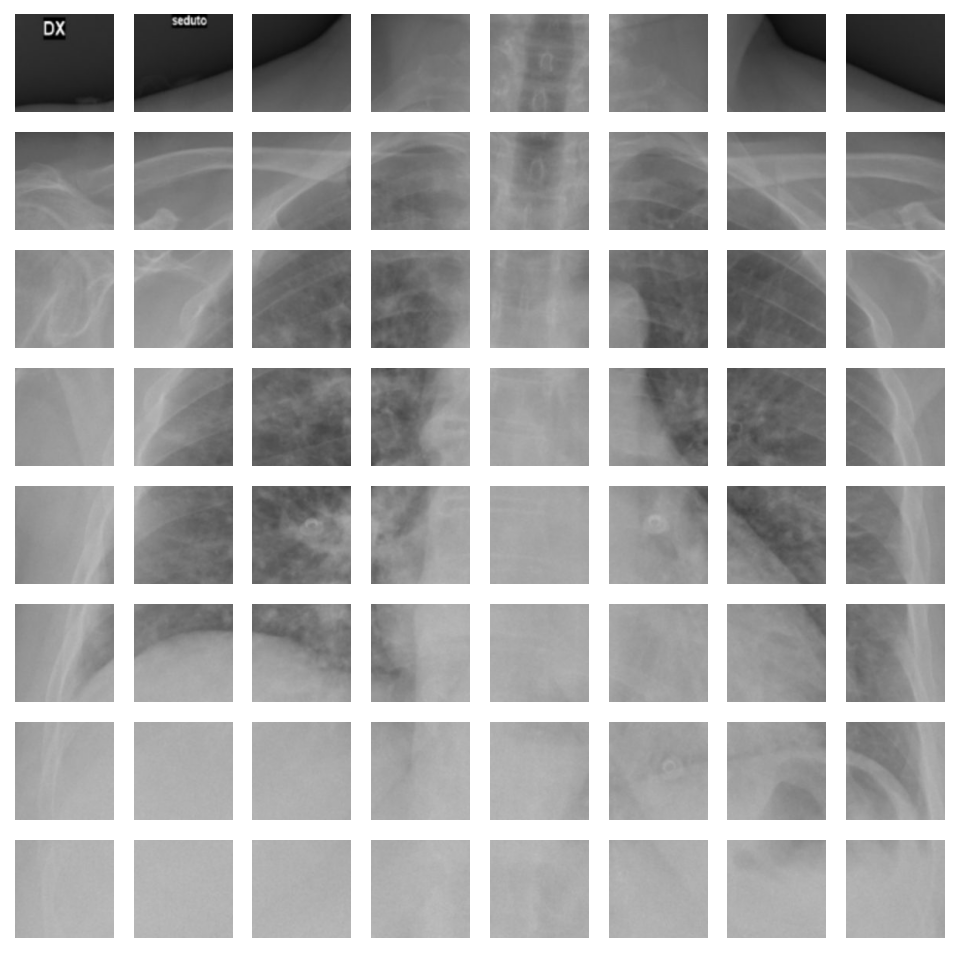

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

def patch_plot(input_path):
    patch_size = 128
    image_path = input_path

    # Load image using PIL
    image = tf.keras.preprocessing.image.load_img(image_path)

    # Convert PIL Image to NumPy array
    imageArray = tf.keras.preprocessing.image.img_to_array(image)

    # Add a batch dimension
    imageArray = imageArray[tf.newaxis, ...]

    patches = tf.image.extract_patches(
        imageArray, sizes=[1, patch_size, patch_size, 1], strides=[1, patch_size, patch_size, 1], rates=[1, 1, 1, 1], padding="VALID"
    )
    patches = tf.reshape(patches, shape=(tf.shape(patches)[0], -1, patch_size * patch_size * 3))

    image_size = 256  # Set your desired image size here

    # Resize NumPy array to the desired image size
    resized_image = tf.image.resize(imageArray, size=(image_size, image_size))

    print(f"Image size: {image_size} X {image_size}")
    print(f"Patch size: {patch_size} X {patch_size}")
    print(f"Patches per image: {patches.shape[1]}")
    print(f"Elements per patch: {patches.shape[-1]}")

    n = int(np.sqrt(patches.shape[1]))
    plt.figure(figsize=(8, 8))
    for i, patch in enumerate(patches[0]):
        ax = plt.subplot(n, n, i + 1)
        patch_img = tf.reshape(patch, (patch_size, patch_size, 3))
        plt.imshow(patch_img.numpy().astype("uint8"))
        plt.axis("off")

    plt.show()

patch_plot(data_path+"covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C-1068x1083.jpeg")


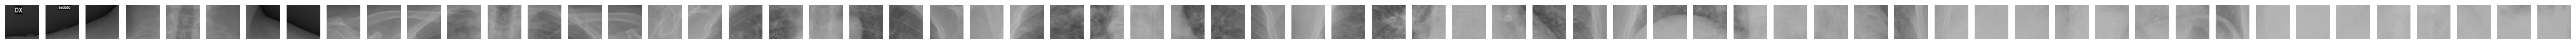

In [ ]:
patch_size_2 = 128
image_path = data_path+"covid/03BF7561-A9BA-4C3C-B8A0-D3E585F73F3C-1068x1083.jpeg"
image = tf.keras.preprocessing.image.load_img(image_path)
imageArray=tf.keras.preprocessing.image.img_to_array(image)
imageArray = imageArray[tf.newaxis , ...]
patches= tf.image.extract_patches(imageArray, sizes=[1 , patch_size_2 , patch_size_2 ,1], strides=[1 , patch_size_2 ,patch_size_2 , 1] , rates=[1,1,1,1], padding="VALID" )
patches=tf.reshape(patches , shape=(tf.shape(patches)[0] , -1 , patch_size_2*patch_size_2*3))


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(n *n , 1))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(1 ,n*n , i + 1)
    patch_img = tf.reshape(patch, (128, 128, 3))
    plt.imshow(patch_img.numpy().astype("uint8"))
    plt.axis("off")
#plt.savefig('patches_flat.png', dpi=600)

Transformer Encoder (Multi Head Attention Layer and Multi Head perception layer(MLP) which is a dense layer)

In [ ]:
class TransformerLayer(tf.keras.layers.Layer):
    def __init__(self , d_model , heads , mlp_rate , dropout_rate=0.1):
        super().__init__()

        self.layernorm_1 = LayerNormalization(epsilon=1e-6)
        self.mha= tf.keras.layers.MultiHeadAttention(heads, d_model//heads , dropout=dropout_rate)

        self.layernorm_2 = LayerNormalization(epsilon=1e-6)
        self.mlp = tf.keras.Sequential([
                                        Dense(d_model * mlp_rate , activation="gelu"),
                                        Dropout(dropout_rate),
                                        Dense(d_model , activation="gelu"),
                                        Dropout(dropout_rate)
        ])
    def call(self , inputs , training=True):
        out_1 = self.layernorm_1(inputs)
        out_1 = self.mha(out_1 , out_1 ,training=training)
        out_1 = inputs + out_1

        out_2= self.layernorm_2(out_1)
        out_2=self.mlp(out_2 , training=training)
        out_2 = out_1 + out_2

        return out_2

In [ ]:
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self , d_model , heads , mlp_rate , num_layers=1 , dropout_rate=0.1):
        super().__init__()

        self.encoders = [TransformerLayer(d_model , heads , mlp_rate , dropout_rate) for _ in range(num_layers)]

    def call(self , inputs , training=True):
        x =inputs

        for layer in self.encoders:
            x = layer(x , training=training)

        return x

Combining the layer to form model

In [ ]:
class VisionTransformer(tf.keras.Model):
    def __init__(self , num_classes , patch_size , num_of_patches , d_model , heads , num_layers , mlp_rate , dropout_rate=0.1):
        super().__init__()

        self.patchEmbedding = PatchEmbedding(patch_size , num_of_patches , d_model)
        self.encoder = TransformerEncoder(d_model , heads , mlp_rate  ,num_layers , dropout_rate)

        self.prediction = tf.keras.Sequential([
                                               tf.keras.layers.Dropout(0.3),
                                               tf.keras.layers.Dense(mlp_rate * d_model , activation="gelu"),
                                               tf.keras.layers.Dropout(0.2),
                                               tf.keras.layers.Dense(num_classes, activation="softmax")


      ])
    def call(self , inputs ,  training=True):
        patches = self.patchEmbedding(inputs)
        encoderResult = self.encoder(patches, training=training)

        clsResult = encoderResult[: , 0 , :]

        prediction = self.prediction(clsResult,
                                     training=training)
        return prediction

TPU 1 minute: 20

t4 GPU 1 minute 180



Training Model

In [ ]:
optimizer = tf.keras.optimizers.Adam(learning_rate = learning_rate)
num_epochs=30
model = VisionTransformer(n_classes,
                          patch_size,
                          num_patches,
                          projection_dim,
                          num_heads,
                          transformer_layers,
                          mlp_rate,
                          dropout_rate=0.1)

model.compile(optimizer = optimizer,
              loss = tf.keras.losses.CategoricalCrossentropy(label_smoothing = 0.1),
              metrics = [tf.keras.metrics.CategoricalAccuracy(name="accuracy"),
                         tf.keras.metrics.TopKCategoricalAccuracy(5, name="top-5-accuracy"),
                        ],
             )


STEP_SIZE_TRAIN = train_gen.n // train_gen.batch_size
STEP_SIZE_VALID = valid_gen.n // valid_gen.batch_size
STEP_SIZE_TEST = test_gen.n // test_gen.batch_size

earlystopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss',
                                                 min_delta = 0,
                                                 patience = 15,
                                                 mode = 'auto',
                                                 verbose = 1)

checkpointer = tf.keras.callbacks.ModelCheckpoint(filepath = './model_ViT.hdf5',
                                                  monitor = 'val_accuracy',
                                                  verbose = 1,
                                                  save_best_only = True,
                                                  save_weights_only = True,
                                                  mode = 'max')

decay_steps = train_gen.n // train_gen.batch_size
initial_learning_rate = learning_rate
lr_decayed_fn = tf.keras.experimental.CosineDecay(initial_learning_rate, decay_steps)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lr_decayed_fn)

callbacks = [earlystopping, lr_scheduler, checkpointer]
# uncomment to start training again
# startTrain_ViT = time()
# history = model.fit(x = train_gen,
#           steps_per_epoch = STEP_SIZE_TRAIN,
#           validation_data = valid_gen,
#           validation_steps = STEP_SIZE_VALID,
#           epochs = num_epochs,
#           callbacks = callbacks)
# time_passed_ViT = time()-startTrain_ViT

Epoch 1/30
91/91 [==============================] - ETA: 0s - loss: 1.2311 - accuracy: 0.3370 - top-5-accuracy: 1.0000
Epoch 1: val_accuracy improved from -inf to 0.38778, saving model to ./model_ViT.hdf5
91/91 [==============================] - 101s 801ms/step - loss: 1.2311 - accuracy: 0.3370 - top-5-accuracy: 1.0000 - val_loss: 1.1254 - val_accuracy: 0.3878 - val_top-5-accuracy: 1.0000 - lr: 0.0010
Epoch 2/30
91/91 [==============================] - ETA: 0s - loss: 1.0996 - accuracy: 0.4068 - top-5-accuracy: 1.0000
Epoch 2: val_accuracy improved from 0.38778 to 0.49574, saving model to ./model_ViT.hdf5
91/91 [==============================] - 73s 809ms/step - loss: 1.0996 - accuracy: 0.4068 - top-5-accuracy: 1.0000 - val_loss: 1.0296 - val_accuracy: 0.4957 - val_top-5-accuracy: 1.0000 - lr: 9.9970e-04
Epoch 3/30
91/91 [==============================] - ETA: 0s - loss: 1.0281 - accuracy: 0.4965 - top-5-accuracy: 1.0000
Epoch 3: val_accuracy improved from 0.49574 to 0.59801, saving mo

In [ ]:
# Save the model
model.save("/content/ViT_model")
# Assuming 'model' is your trained model
model.save('/content/drive/MyDrive/BTP_GAURAV/Deep_Learning/Model/ViT_saved_model', save_format='tf')

# Assuming 'model' is your trained model
model.save_weights('/content/drive/MyDrive/BTP_GAURAV/Deep_Learning/Model/ViT_weights.h5')


# Save the training history
np.save('/content/history_ViT.npy', history.history)

# Zip the model directory and history file
!zip -r ViT_model_and_history.zip /content/ViT_model /content/history_ViT.npy

# Move the zip file to Google Drive
!mv ViT_model_and_history.zip '/content/drive/MyDrive/BTP_GAURAV/Deep_Learning/Dataset/'

  adding: content/ViT_model/ (stored 0%)
  adding: content/ViT_model/variables/ (stored 0%)
  adding: content/ViT_model/variables/variables.data-00000-of-00001 (deflated 10%)
  adding: content/ViT_model/variables/variables.index (deflated 78%)
  adding: content/ViT_model/fingerprint.pb (stored 0%)
  adding: content/ViT_model/keras_metadata.pb (deflated 95%)
  adding: content/ViT_model/saved_model.pb (deflated 92%)
  adding: content/ViT_model/assets/ (stored 0%)
  adding: content/history_ViT.npy (deflated 54%)


In [ ]:
model.save("ViT_model")
!zip -r file.zip . -i /ViT_model
np.save('history_ViT.npy',history.history)
!mv ViT_model '/content/drive/MyDrive/BTP_GAURAV/Deep_Learning/Dataset/'
!mv history_ViT.npy '/content/drive/MyDrive/BTP_GAURAV/Deep_Learning/Dataset/'


Scanning files .
	zip warning: name not matched: drive/MyDrive/First Year/MA 101 - Calculus -1 (2023)
	zip warning: name not matched: drive/MyDrive/Material for 1st Year
......	zip warning: name not matched: drive/.shortcut-targets-by-id/1l7N-XZL8RnKZIDnsRq6qunAw9dS6zIRg/FY reference 2/MA 101 - Calculus -1 (2023)
	zip warning: zip file empty
mv: inter-device move failed: 'ViT_model' to '/content/drive/MyDrive/BTP_GAURAV/Deep_Learning/Dataset/ViT_model'; unable to remove target: Directory not empty


In [ ]:
model.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_embedding (PatchEmbe  multiple                  29120     
 dding)                                                          
                                                                 
 transformer_encoder (Trans  multiple                  267776    
 formerEncoder)                                                  
                                                                 
 sequential_8 (Sequential)   (None, 3)                 8707      
                                                                 
Total params: 305603 (1.17 MB)
Trainable params: 305603 (1.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


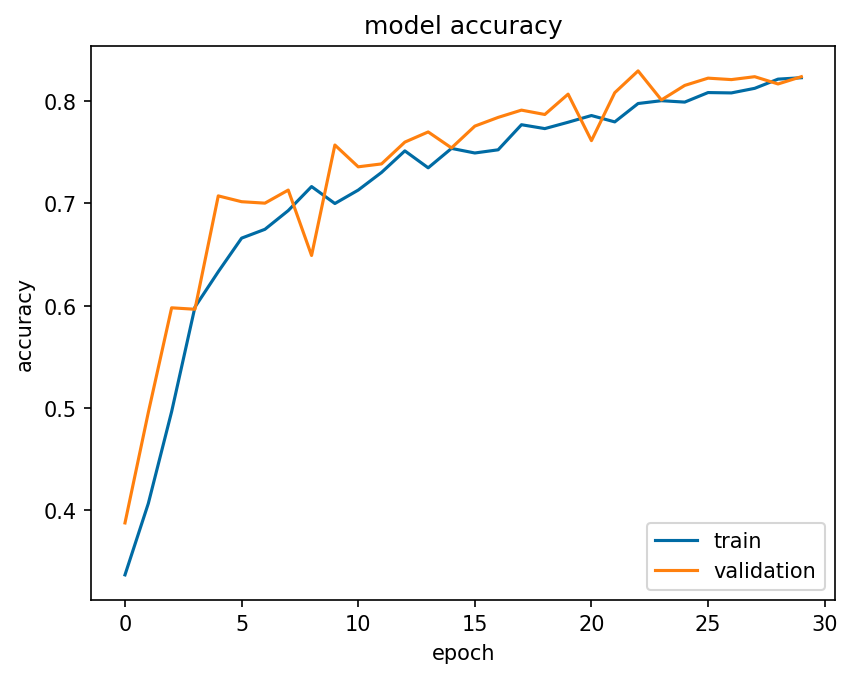

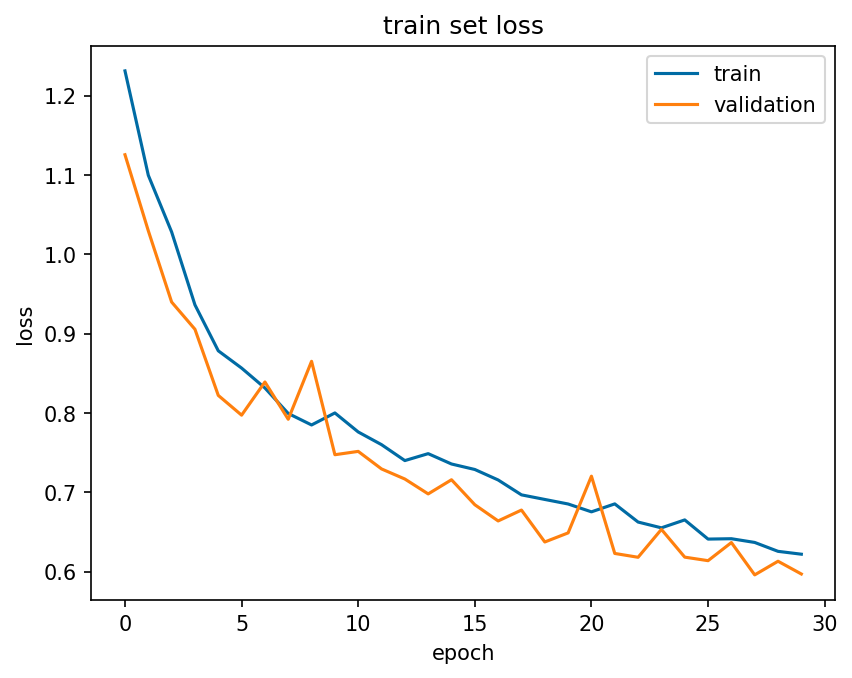

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='lower right')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('train set loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper right')
plt.show()

In [ ]:
test_gen.reset()
predY=model.predict_generator(
        test_gen,
        steps=STEP_SIZE_TEST,
        verbose=1)
testY = test_gen.classes

915/915 [==============================] - 26s 28ms/step


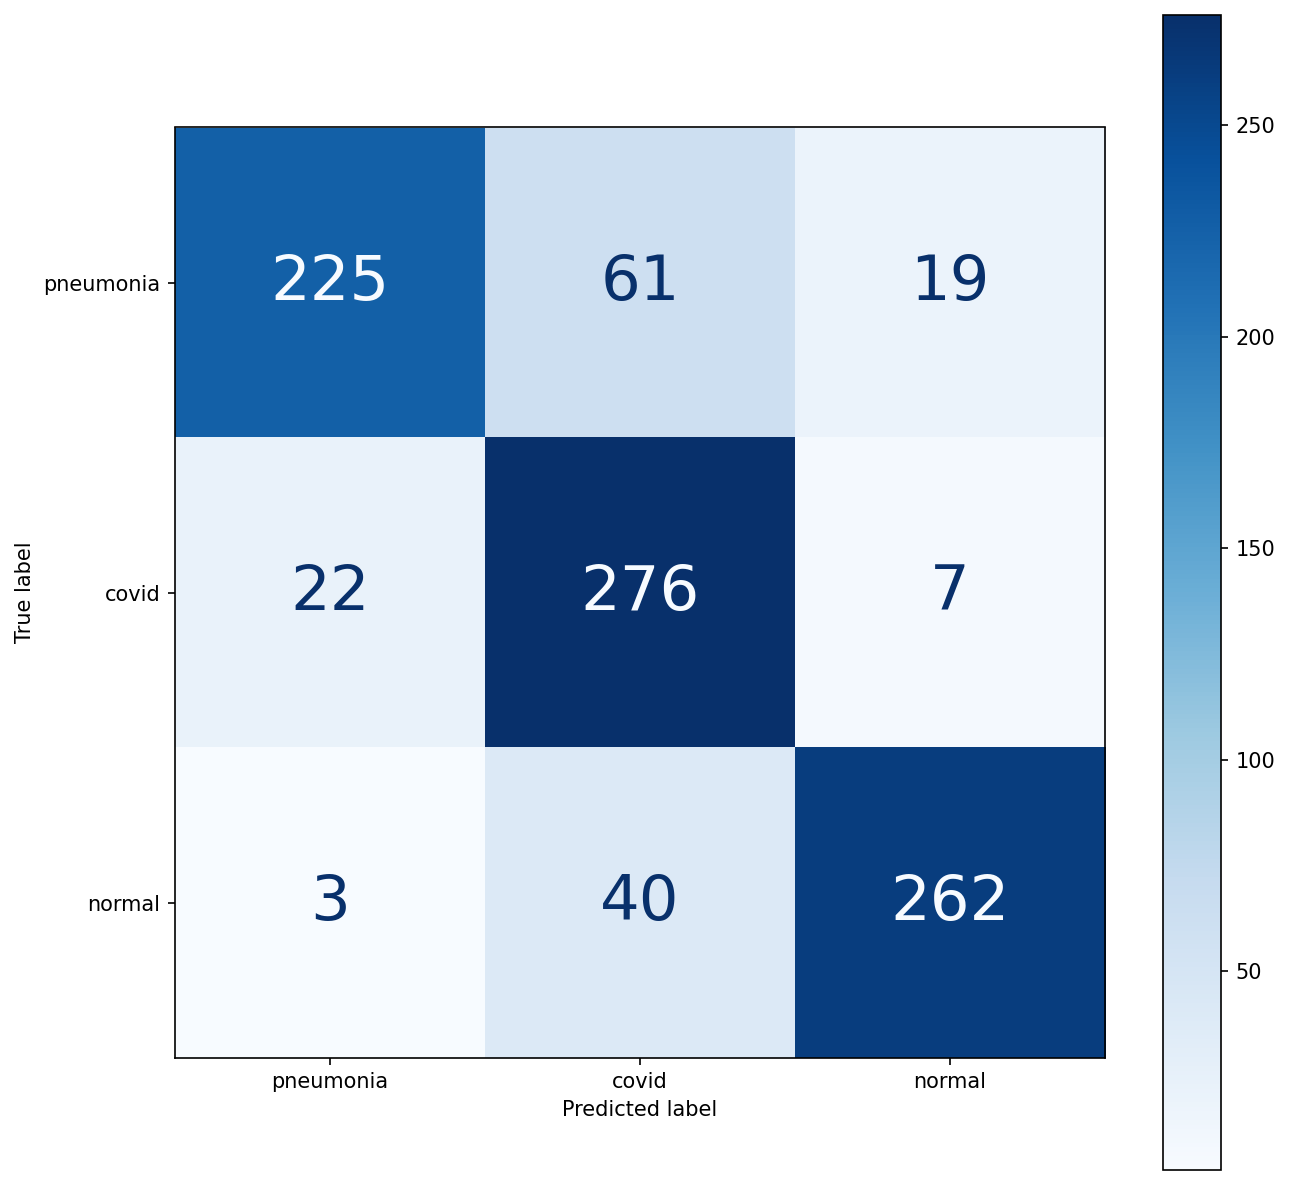

In [ ]:
cm = confusion_matrix(testY, np.argmax(predY, axis = -1)) # confusion matrix
cr=(classification_report(testY, np.argmax(predY, axis = -1), target_names=class_to_label_map, output_dict=True, digits=4)) #other scores

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()

In [ ]:
# Save the weights
model.save_weights('/content/drive/MyDrive/BTP_GAURAV/Deep_Learning/Model/30epochs/weight.h5')

# # Create a new model instance
# model1 = create_model()

# # Restore the weights
model.load_weights('/content/drive/MyDrive/BTP_GAURAV/Deep_Learning/Model/30epochs/weight.h5')

# # Evaluate the model
# loss, acc = model1.evaluate(test_images, test_labels, verbose=2)
# print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

Testing saved model

In [ ]:
test_gen.reset()
predY=model.predict_generator(
        test_gen,
        steps=STEP_SIZE_TEST,
        verbose=1)
testY = test_gen.classes

915/915 [==============================] - 41s 44ms/step


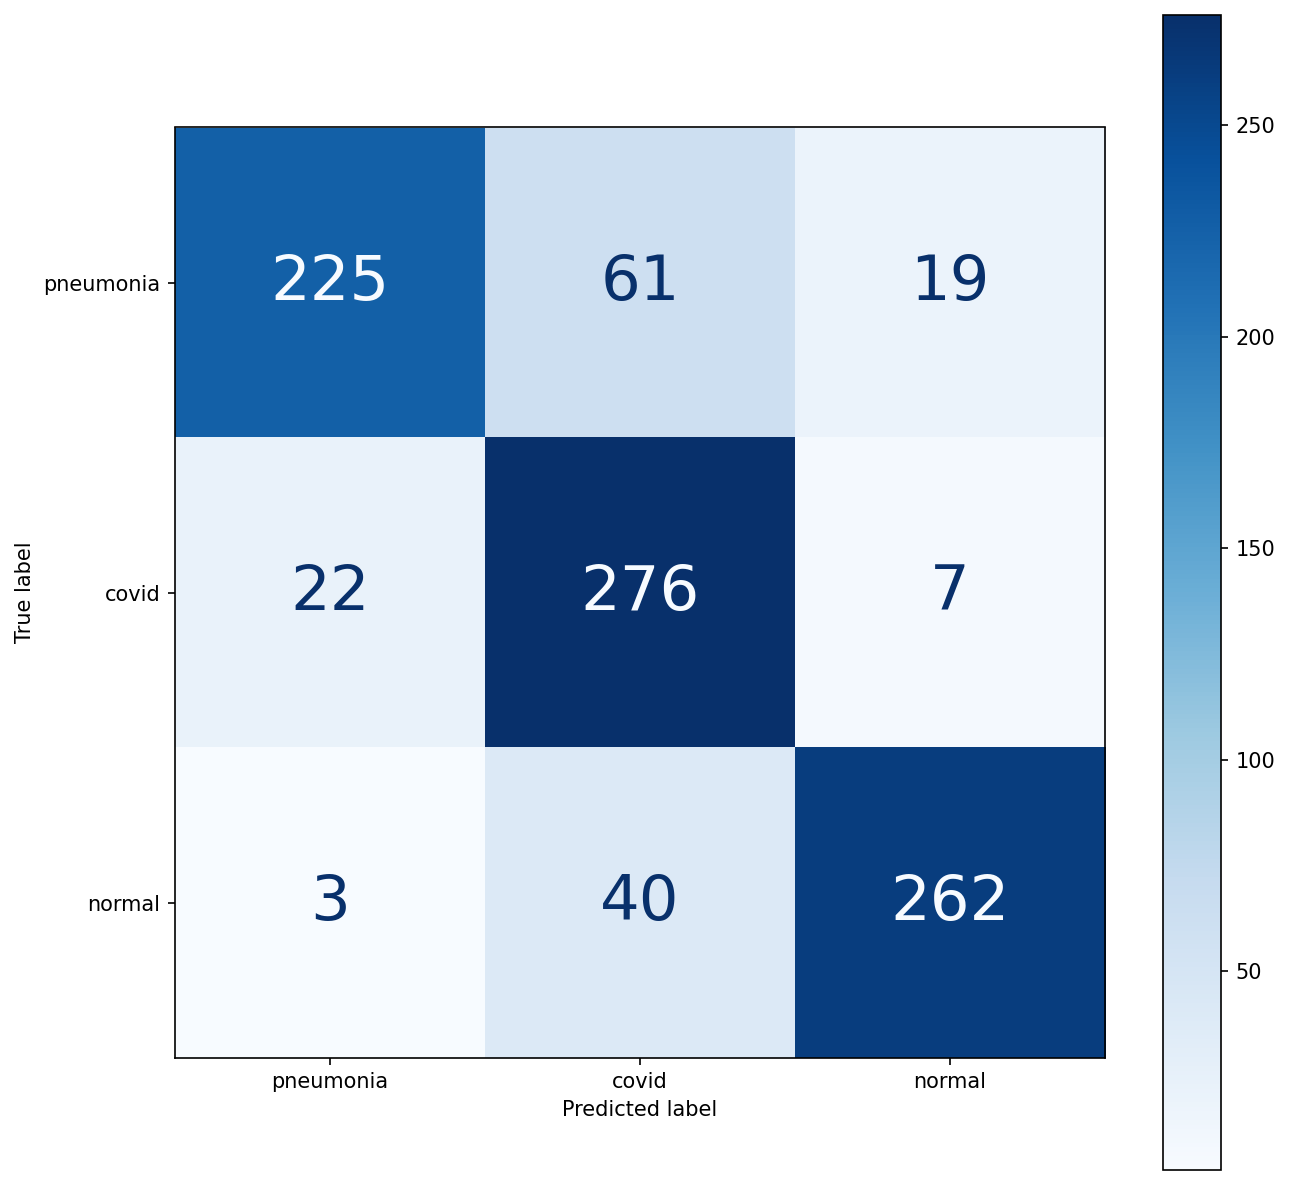

In [ ]:
cm = confusion_matrix(testY, np.argmax(predY, axis = -1)) # confusion matrix
cr=(classification_report(testY, np.argmax(predY, axis = -1), target_names=class_to_label_map, output_dict=True, digits=4)) #other scores

labels = class_to_label_map.keys()
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(cmap=plt.cm.Blues,ax=ax)
for labels in disp.text_.ravel():
    labels.set_fontsize(30)
plt.show()